In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration

gpus = list_physical_devices('GPU')
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=1200)])
print(len(gpus), "Physical GPUs")

def df_to_X_y(df, window_size=30):
    df_as_np = df.to_numpy()
    X,y = [], []
    for i in range(len(df_as_np)-window_size):
        if abs(df_as_np[i+window_size][0] - (window_size*(df_as_np[i-1][0]-df_as_np[i][0])+df_as_np[i][0])) < 1:
            X.append(df_as_np[i:i+window_size])
            y.append(df_as_np[i+window_size][-1])
    return np.array(X), np.array(y)

2023-03-31 17:31:10.652315: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


1 Physical GPUs


2023-03-31 17:31:11.402502: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-31 17:31:11.403128: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-31 17:31:11.442786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 17:31:11.443091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2023-03-31 17:31:11.443111: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-31 17:31:11.444410: I tensorflow/stream_executor/platfo

In [63]:
df = pd.read_csv("all_cubesat_data_only_GRBAlpha.csv")
#df["cps"] = np.log10(df["cps"]+1)
df

,time,longitude,latitude,altitude,cps
0,2021-04-14 20:49:16.000,0.995211,0.474772,541.646,98.375
1,2021-04-14 20:49:56.000,0.685935,0.157233,540.863,92.950
2,2021-04-14 20:51:16.000,-0.543929,0.993196,539.458,82.975
3,2021-04-14 20:51:56.000,-0.931717,-0.864385,538.849,78.550
4,2021-04-14 20:52:36.000,-0.973822,0.392487,538.309,74.450
...,...,...,...,...,...
2053931,2023-03-26 06:04:13.878,-0.975323,-0.725665,532.206,75.000
2053932,2023-03-26 06:04:14.878,-0.972604,-0.767544,532.202,71.000
2053933,2023-03-26 06:04:15.878,-0.969744,-0.806377,532.198,54.000
2053934,2023-03-26 06:04:16.878,-0.966489,-0.842011,532.194,70.000


In [3]:
grb = ["2022-08-15 14:34:56.390",
"2022-08-16 00:08:32.360",
"2022-08-26 10:21:19.720",
"2022-08-29 14:37:50.308",
"2022-09-04 12:13:25.000",
"2022-09-15 05:13:40.900",
"2022-09-26 10:38:19.750",
"2022-09-27 05:36:20.950",
"2022-10-09 13:16:59.99",
"2022-10-14 07:12:28.77",
"2022-10-14 17:27:39.767",
"2022-10-20 05:23:52.830",
"2022-10-22 22:55:48.91",
"2022-10-29 01:05:27.310",
"2022-11-07 01:22:52.46",
"2022-11-11 05:54:27.320",
"2022-11-11 11:39:28.529",
"2022-11-11 13:49:11.120",
"2022-11-12 06:18:04.36",
"2022-11-19 15:02:53.640",
"2022-11-22 02:43:26.65",
"2022-11-27 08:27:10.520",
"2022-12-06 12:22:47.360",
"2022-12-29 18:18:17.662",
"2023-01-02 00:22:12.970",
"2023-02-04 21:44:27.200",
"2023-02-07 04:40:45.260",
"2023-02-10 03:00:26.000",
"2023-02-11 15:45:01.041",
"2023-02-11 17:36:11.870",
"2023-02-22 13:46:10.615",
"2023-03-04 14:35:49.140",
"2023-03-05 13:40:29.28",
"2023-03-07 15:44:06.67",
"2023-03-08 22:41:39.690",
"2023-03-12 06:07:09.590"]

# converts burst time into julian date - int of first data
grb_list = []
for i in range(len(grb)):
    t = Time(grb[i], format='iso', scale='utc')
    grb_list.append(t.jd - 2459319)


In [ ]:
grb_list

In [4]:
# converts time into julian date - int of first data

new_time = []
for i in range(len(df["time"])):
    thyme = Time(df["time"][i],format='iso', scale='utc')
    new_time.append(thyme.jd - 2459319)
df["time"] = new_time

In [7]:
# makes array of known grbs and removes them from data

grb_dataq = []

for i, t in enumerate(df["time"]):
    for value in grb_list:
        if np.round(value,5) == np.round(t,5):
            start = max(0, i - 256)
            end = min(len(df["time"]), i + 32)
            grb_dataq.append(df[start:end].to_numpy())
            df.drop(df.index[start:end],0,inplace=True)
            print(end)

KeyboardInterrupt: 

In [55]:
# makes array of known grbs and removes them from data

grb_dataq = []


for value in grb_list:
    i = np.argmin(abs(value - df["time"]))
    start = max(0, i - 256)
    end = min(len(df["time"]), i + 32)
    grb_dataq.append(df[start:end].to_numpy())
    df.drop(df.index[start:end],0,inplace=True)
    print(i)

/tmp/ipykernel_47887/2982490677.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.index[start:end],0,inplace=True)


204094
212122
288977
379675
495476
579405
584138
587494
607862
624448
628378
643175
655096
676884
740722
804988
823164
825836
843470
908002
934254
956568
1070495
1143325
1170346
1222864
1275855
1345476
1359989
1365202
1537269
1692487
1711156
1749315
1754844
1806917


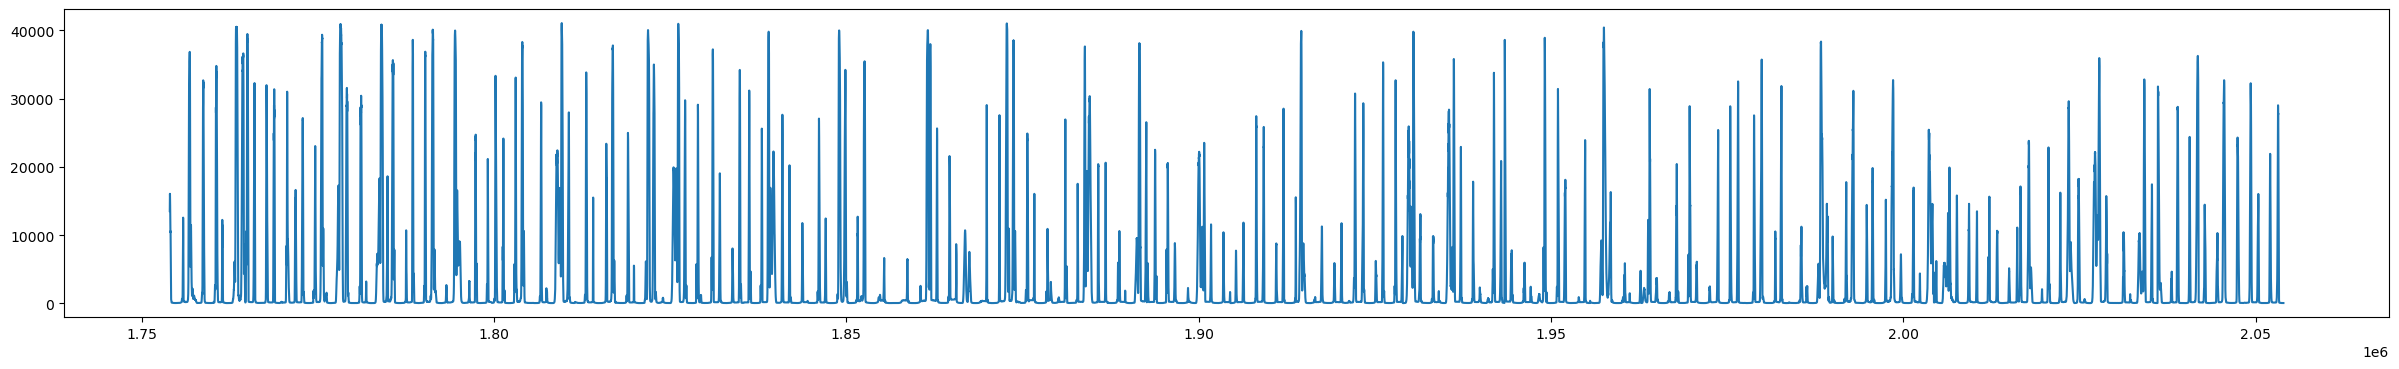

In [82]:
plt.figure(figsize=(30,4))
plt.plot(df["cps"][-300000:].rolling(50).mean())

In [57]:
grb_list

[488.10759710660204,
 488.5059300926514,
 498.9314782405272,
 502.10961004626006,
 508.0093171298504,
 518.717834490817,
 529.9432841436937,
 530.7335758102126,
 543.053472106345,
 547.800332986284,
 548.2275435994379,
 553.7249170136638,
 556.4554271991365,
 562.5454549770802,
 571.5575516205281,
 575.7461495371535,
 575.9857468632981,
 576.0758231482469,
 576.7625504629686,
 584.1270097224042,
 586.6135028935969,
 591.852205092553,
 601.0158259258606,
 624.2627044213004,
 627.5154278934933,
 661.4058703705668,
 663.6949682869017,
 666.6253009261563,
 668.1562620485201,
 668.233470717445,
 679.0737339700572,
 689.1082076388411,
 690.0697833332233,
 692.1556327547878,
 693.4455982637592,
 696.7549721063115]

In [10]:
np.shape(grb_dataq)

(36, 288, 5)

In [ ]:
np.shape(grb_dataq)

In [ ]:
grb_dataq.to_csv("GRBAlpha_data_bursts.csv")

In [ ]:
grb_dataq[0][:,1:5]

In [ ]:
blaaah

In [ ]:
# converts data into WINDOW_SIZE chunks
WINDOW_SIZE = 128
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

In [ ]:
X_train, y_train, X_test, y_test = X1[0:1630000,:,1:],y1[0:1630000],X1[1630000:,:,1:],y1[1630000:]

In [ ]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE,4)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(8, 'relu'))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

In [ ]:
model1.compile(loss=MeanSquaredError(),
               optimizer=Adam(learning_rate=0.01),
               metrics=RootMeanSquaredError())


callback = [ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2,
                              min_lr=0.0001),
           ModelCheckpoint("/home/mchobola/diplo/models/LSTM_{}-{}-{}.h5".format(datetime.datetime.now().day,datetime.datetime.now().month,datetime.datetime.now().hour), 
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min'),
           EarlyStopping(monitor='val_loss', patience=5)]

history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50,callbacks=[callback])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()

In [ ]:
model1.save('models/LSTM_newest.h5')

In [11]:
model1 = load_model('models/LSTM_4var_win_128.h5')

2023-03-31 17:57:44.483039: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 17:57:44.483365: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-31 17:57:44.483503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 17:57:44.483834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 46

(64, 4)


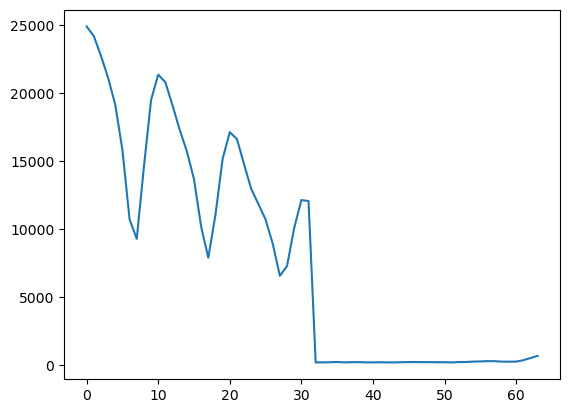

In [54]:
grr = grb_dataq[3][-64:,1:5]
print(np.shape(grr))
plt.plot(10**(grr[:,-1]))

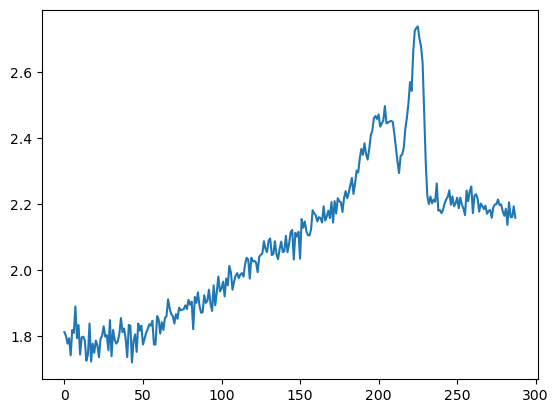

In [43]:
plt.plot(grr[:,-1])

In [33]:
y_pred0 = []
X0 = grr[:128].copy()
for i in range(128):
    pred = model1.predict(X0.reshape(1,128,4))[0]
    y_pred0.append(pred)
    X0 = grr[i+1:i+128+1].copy()
    X0[:,-1] = pred 

(array([ 6.,  1.,  4., 17., 13.,  8., 40., 21., 10.,  8.]),
 array([-0.81155198, -0.73008557, -0.64861916, -0.56715274, -0.48568633,
        -0.40421992, -0.32275351, -0.2412871 , -0.15982068, -0.07835427,
         0.00311214]),
 <BarContainer object of 10 artists>)

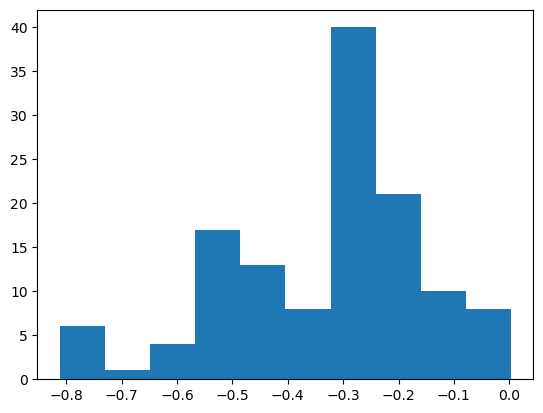

In [34]:
plt.hist((np.array(y_pred0).T[0]-np.array(grr[128:256,-1])))

In [35]:
gustav = np.array(grr[127:255,-1])

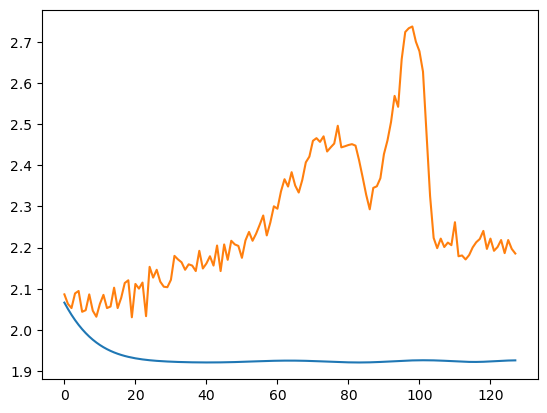

In [36]:
plt.plot(np.array(y_pred0).T[0])
plt.plot(gustav)

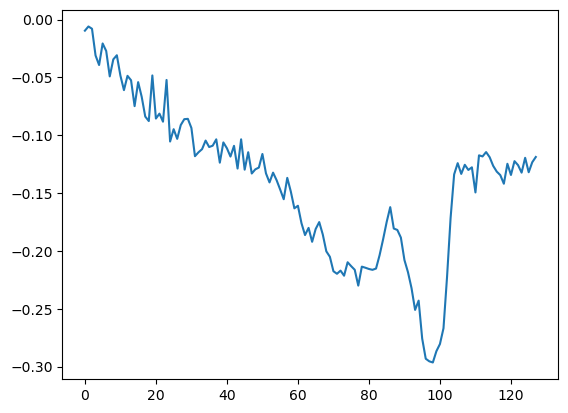

In [37]:
plt.plot((np.array(y_pred0).T[0]-gustav)/gustav)